# SIMULATION MONTE CARLO POUR LE MODELE XGB

In [ ]:
import os
os.chdir(r"C:\Users\User\mon_projet_data") #Probleme avec cwd chemin a corriger pour plus hardcoder
print("CWD corrigé ->", os.getcwd())

import sys, psycopg2
sys.path.append(os.path.abspath('..'))  
from scripts.monte_carlo import MonteCarloSimulator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

CWD corrigé -> C:\Users\User\mon_projet_data


In [3]:
print(" Initialisation du simulateur Monte Carlo saison 2024/2025...")
saison_a_simuler = 6

# 1. CHARGER LE SIMULATEUR
simulateur = MonteCarloSimulator()  
print("Simulateur chargé")

def get_connection():
    return psycopg2.connect(
        user=os.getenv("user"),
        password=os.getenv("password"), 
        host=os.getenv("host"),
        port=os.getenv("port"),
        dbname=os.getenv("dbname")
    )

conn = get_connection()
df_complet = pd.read_sql(f"SELECT * FROM training_modele_season WHERE season_id = {saison_a_simuler}", conn)
conn.close()



df_saison = df_complet[df_complet['season_id'] == saison_a_simuler].copy()

 Initialisation du simulateur Monte Carlo saison 2024/2025...
 Modèle chargé - Accuracy: 0.6684
Simulateur chargé


C:\Users\User\AppData\Local\Temp\ipykernel_21312\2537413413.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_complet = pd.read_sql(f"SELECT * FROM training_modele_season WHERE season_id = {saison_a_simuler}", conn)


## Préparation des données

In [4]:
from sklearn.preprocessing import LabelEncoder

colonnes_a_supprimer = ['match_id', 'date_match', 'created_at', 'updated_at']
colonnes_existantes = [col for col in colonnes_a_supprimer if col in df_saison.columns]
df_clean = df_saison.drop(columns=colonnes_existantes)
print(df_clean.head())
X = df_clean.drop(columns=['result'])
y = df_clean['result']
print(y.head())
le = LabelEncoder()
y_encoded = le.fit_transform(y)

   season_id  home_team_id  away_team_id  points_home  points_away  \
0          6            16             9          0.0          0.0   
1          6            10            13          0.0          0.0   
2          6             8             4          0.0          0.0   
3          6            17            21          0.0          0.0   
4          6            19             2          0.0          0.0   

   goal_diff_home  goal_diff_away  goals_scored_home  goals_scored_away  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   

   goals_conceded_home  ...  possession_away  shots_on_target_home  \
0                  0.0  ...              0.0              

#  LANCER LES SIMULATIONS


Mapping entre l'id de l'équipe et son nom

In [5]:
conn = get_connection()
df_teams = pd.read_sql("SELECT DISTINCT team_id, name FROM public.teams", conn)
conn.close()

# Construire un dict id->nom 
team_map = dict(zip(df_teams['team_id'].astype(str), df_teams['name']))

teams_home_ids = df_saison['home_team_id'].astype(str).tolist()
teams_away_ids = df_saison['away_team_id'].astype(str).tolist()

# 4) Convertir en noms (fallback = l’ID si inconnu)
teams_home_names = [team_map.get(tid, tid) for tid in teams_home_ids]
teams_away_names = [team_map.get(tid, tid) for tid in teams_away_ids]


C:\Users\User\AppData\Local\Temp\ipykernel_21312\3616430601.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_teams = pd.read_sql("SELECT DISTINCT team_id, name FROM public.teams", conn)


Lancement de la simulation

In [6]:
colonnes_a_supprimer = ['match_id','date_match','created_at','updated_at']
df_clean = df_saison.drop(columns=[c for c in colonnes_a_supprimer if c in df_saison.columns])
X = df_clean.drop(columns=[c for c in ['result'] if c in df_clean.columns])
X_features = simulateur.preparer_calendrier(X)


# Lancer la simulation avec les noms d’équipes
resultats, probas = simulateur.simuler_saison_complete(
    X_features,
    teams_home=teams_home_names,
    teams_away=teams_away_names,
    n_simulations=1000,
    seed=42
)

simulateur.generer_rapport()

 Lancement de 1000 simulations Monte Carlo...
 Probabilités calculées pour 380 matchs
     proba_defaite  proba_nul  proba_victoire
0         0.445620   0.004752        0.549628
1         0.989110   0.006719        0.004171
2         0.443141   0.553557        0.003302
3         0.002522   0.002374        0.995104
4         0.463311   0.532935        0.003754
..             ...        ...             ...
375       0.462391   0.004286        0.533323
376       0.397702   0.415664        0.186635
377       0.777467   0.219972        0.002561
378       0.359515   0.637321        0.003164
379       0.001764   0.093613        0.904622

[380 rows x 3 columns]


Simulations: 100%|██████████| 1000/1000 [00:22<00:00, 44.94it/s]


 RAPPORT MONTE CARLO - SIMULATION SAISON
\ CLASSEMENT MOYEN (par points moyens):
 1. Liverpool             80.0 pts (95% CI: 70.0-89.0)
 2. Man City              77.1 pts (95% CI: 67.0-88.0)
 3. Arsenal               74.4 pts (95% CI: 64.0-85.0)
 4. Newcastle             67.7 pts (95% CI: 57.0-78.0)
 5. Aston Villa           66.5 pts (95% CI: 57.0-76.0)
 6. Brighton              57.4 pts (95% CI: 46.0-69.0)
 7. Chelsea               56.4 pts (95% CI: 46.0-67.0)
 8. Brentford             52.9 pts (95% CI: 42.0-63.0)
 9. Crystal Palace        50.6 pts (95% CI: 40.0-61.0)
10. Bournemouth           50.4 pts (95% CI: 40.0-62.0)
11. Man United            49.7 pts (95% CI: 39.0-61.0)
12. Nott'm Forest         49.7 pts (95% CI: 38.0-61.0)
13. Fulham                47.0 pts (95% CI: 36.0-59.0)
14. Wolves                43.6 pts (95% CI: 33.0-54.0)
15. Everton               43.2 pts (95% CI: 34.0-53.0)
16. Tottenham             42.7 pts (95% CI: 31.0-55.0)
17. West Ham              42.1 pts (95

Calcule du classement de la vraie saison

In [7]:
df_simulation_reel = pd.DataFrame({
    'home_team': teams_home_names,
    'away_team': teams_away_names,
    'result': df_saison['result'].values
})
classement_reel = simulateur.simuler_saison_reel(df_simulation_reel)

print("\n CLASSEMENT RÉEL")
for i, (eq, pts) in enumerate(sorted(classement_reel.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"{i:2d}. {eq:20} {pts} pts")



 CLASSEMENT RÉEL
 1. Liverpool            84 pts
 2. Arsenal              74 pts
 3. Man City             71 pts
 4. Chelsea              69 pts
 5. Aston Villa          66 pts
 6. Newcastle            66 pts
 7. Nott'm Forest        65 pts
 8. Brighton             61 pts
 9. Bournemouth          56 pts
10. Brentford            56 pts
11. Fulham               54 pts
12. Crystal Palace       53 pts
13. Everton              48 pts
14. West Ham             43 pts
15. Man United           42 pts
16. Wolves               42 pts
17. Tottenham            38 pts
18. Leicester            25 pts
19. Ipswich              22 pts
20. Southampton          12 pts


### 6. VISUALISATIONS


 Génération des visualisations...


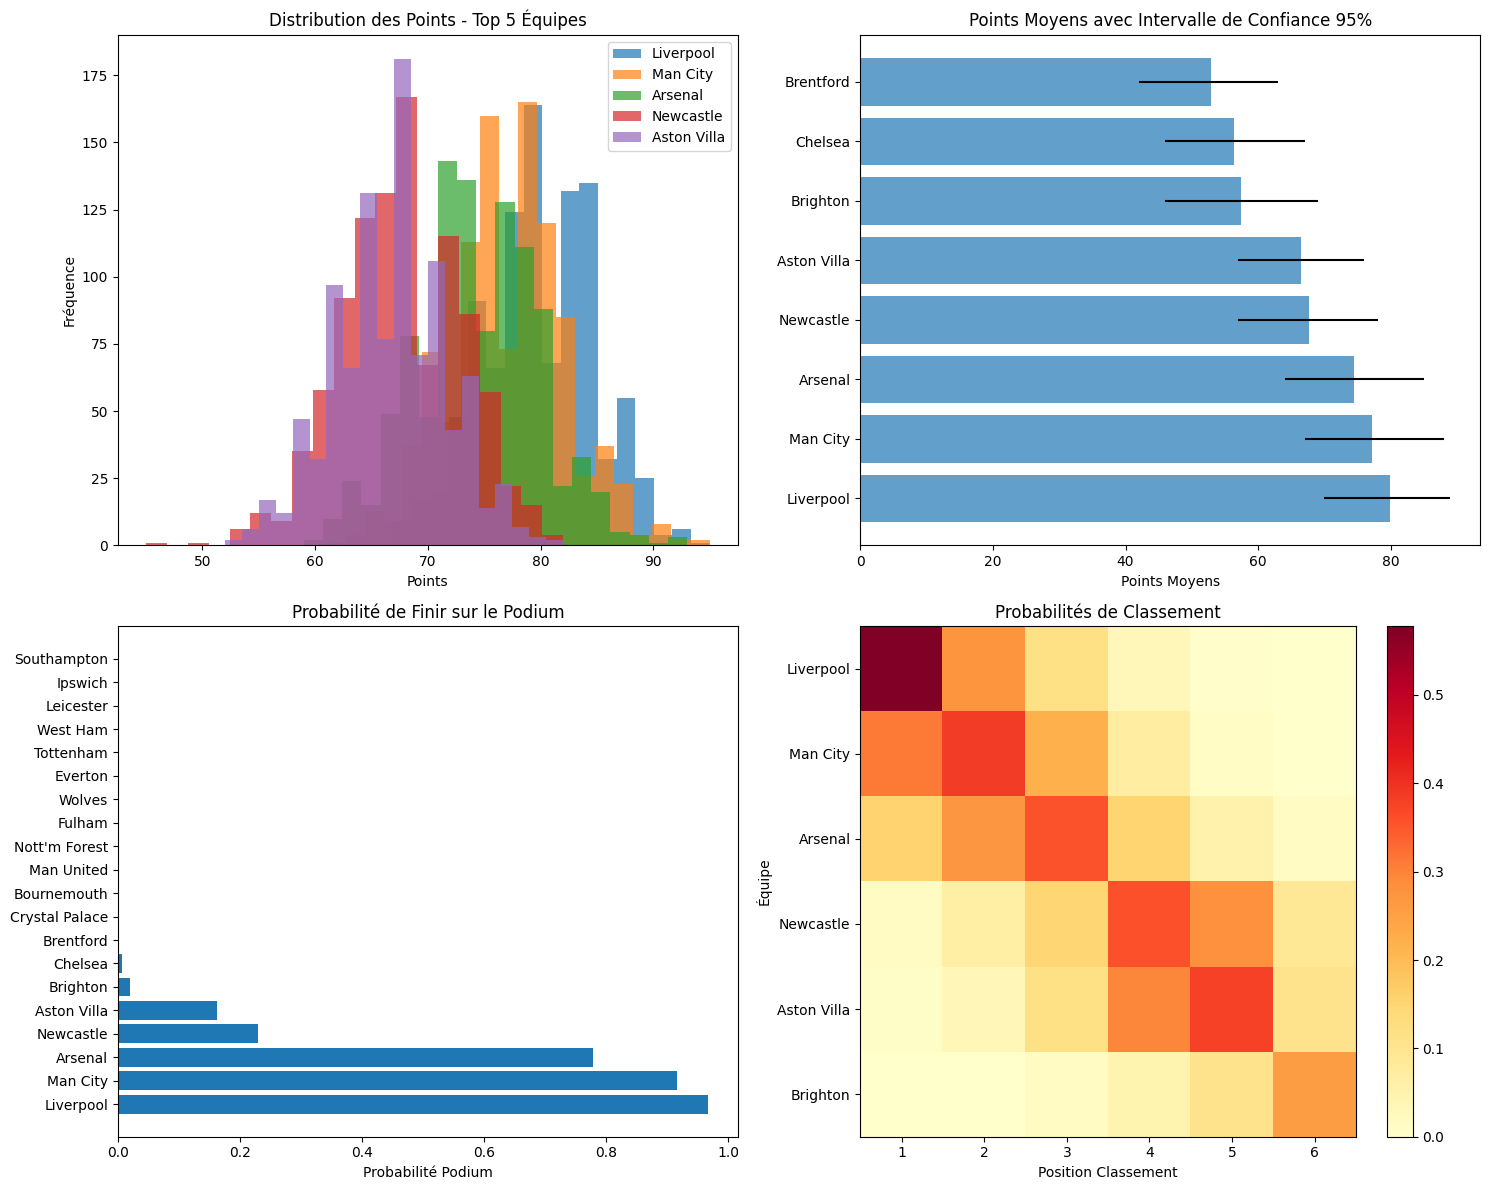

In [8]:
print("\n Génération des visualisations...")
simulateur.visualiser_resultats()

# ANALYSE DÉTAILLÉE


In [9]:
print("\n ANALYSE DÉTAILLÉE PAR ÉQUIPE:")
for equipe, stats in list(resultats.items()):  
    if equipe != 'probabilites_classement':
        print(f"\n{equipe}:")
        print(f"   Points moyens: {stats['moyenne_points']:.1f}")
        print(f"   Intervalle 95%: {stats['intervalle_confiance_95'][0]:.1f} - {stats['intervalle_confiance_95'][1]:.1f}")
        print(f"   Probabilité titre: {resultats['probabilites_classement'][equipe].get(1, 0):.2%}")


 ANALYSE DÉTAILLÉE PAR ÉQUIPE:

Fulham:
   Points moyens: 47.0
   Intervalle 95%: 36.0 - 59.0
   Probabilité titre: 0.00%

Liverpool:
   Points moyens: 80.0
   Intervalle 95%: 70.0 - 89.0
   Probabilité titre: 57.80%

Everton:
   Points moyens: 43.2
   Intervalle 95%: 34.0 - 53.0
   Probabilité titre: 0.00%

Brighton:
   Points moyens: 57.4
   Intervalle 95%: 46.0 - 69.0
   Probabilité titre: 0.00%

Newcastle:
   Points moyens: 67.7
   Intervalle 95%: 57.0 - 78.0
   Probabilité titre: 1.70%

Bournemouth:
   Points moyens: 50.4
   Intervalle 95%: 40.0 - 62.0
   Probabilité titre: 0.00%

Arsenal:
   Points moyens: 74.4
   Intervalle 95%: 64.0 - 85.0
   Probabilité titre: 15.50%

Aston Villa:
   Points moyens: 66.5
   Intervalle 95%: 57.0 - 76.0
   Probabilité titre: 0.90%

Brentford:
   Points moyens: 52.9
   Intervalle 95%: 42.0 - 63.0
   Probabilité titre: 0.00%

Chelsea:
   Points moyens: 56.4
   Intervalle 95%: 46.0 - 67.0
   Probabilité titre: 0.00%

Man City:
   Points moyens: 77.

## Comparaison au vrai classement


 Comparaison au vrai classement...
{'MAE_points': np.float64(5.03), 'RMSE_points': np.float64(6.44), 'Spearman_ranks': np.float64(0.929), 'Top4_overlap': '3/4', 'Champion_model': 'Liverpool', 'Champion_reel': 'Liverpool', 'Champion_match': True}


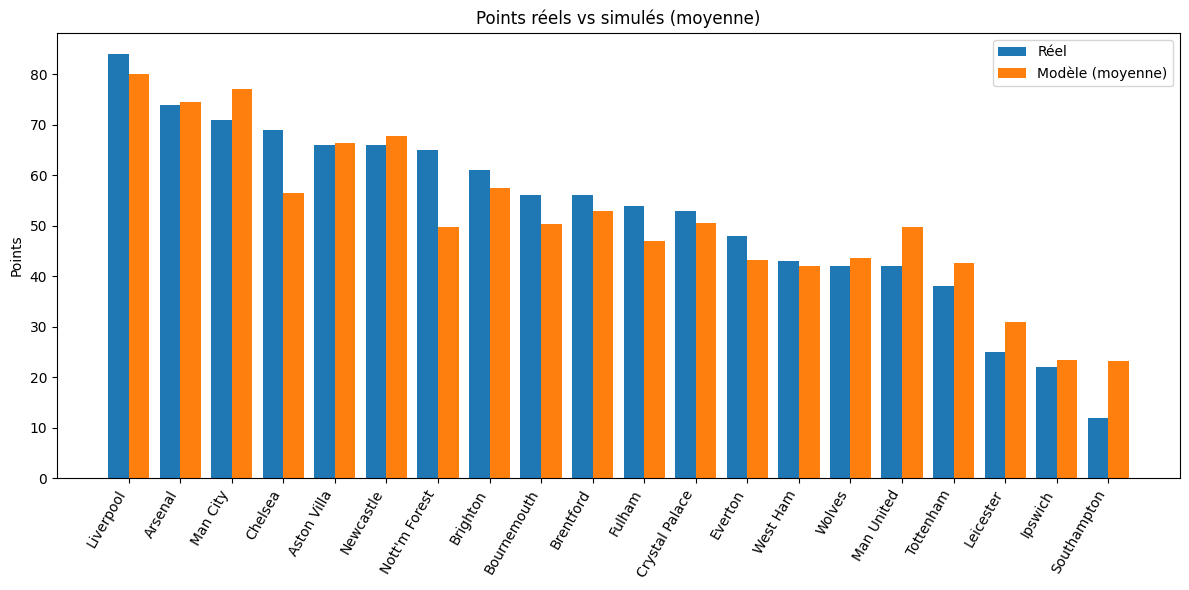

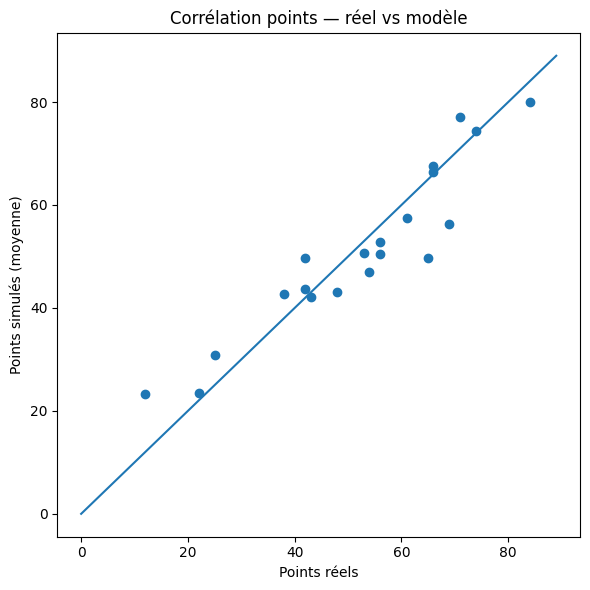

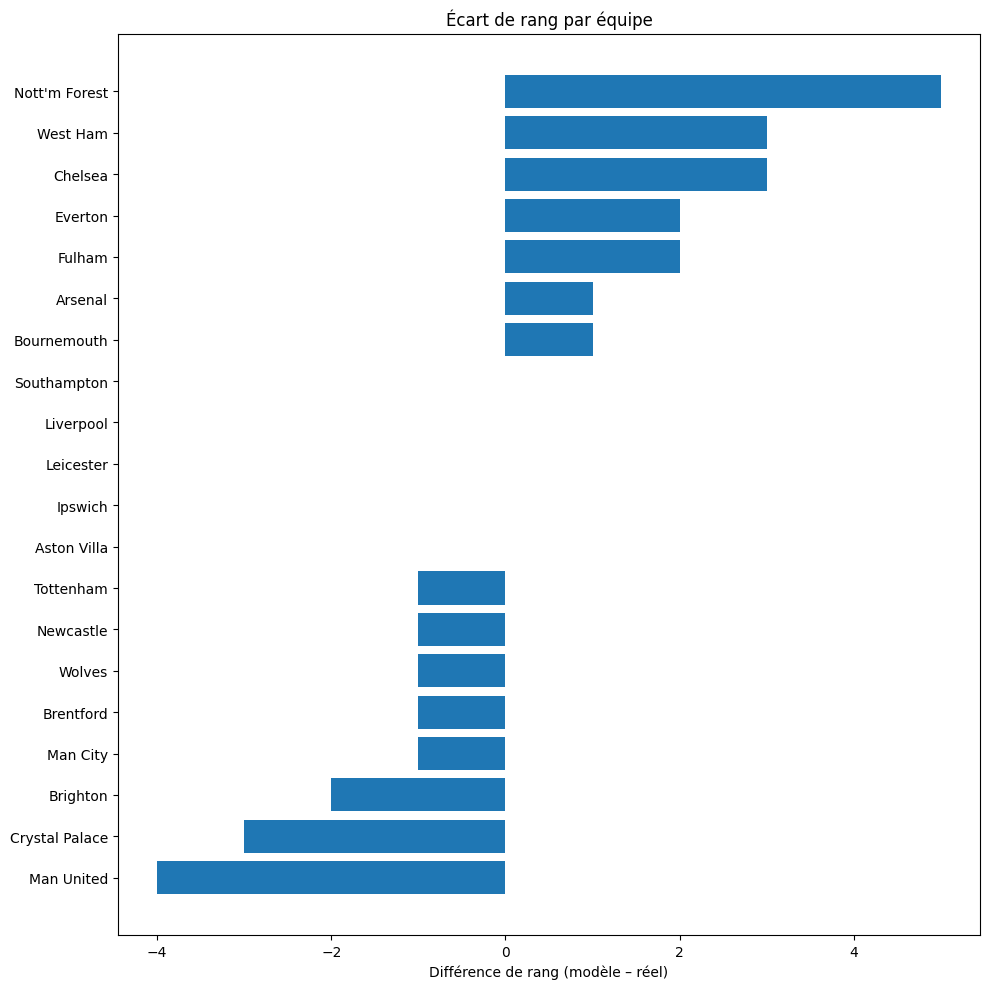

In [10]:
print("\n Comparaison au vrai classement...")
df_comp, metrics = simulateur.comparer_reel_modele(classement_reel)
print(metrics)
simulateur.visualiser_comparaisons()
